<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout


In [3]:

# Load MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize the images to [-1, 1]
x_train = (x_train.astype("float32") - 127.5) / 127.5
y_train = y_train.reshape(-1, 1)

x_train = x_train[:1000]
y_train = y_train[:1000]

x_train = x_train.astype('float32') / 255.0


11490434/11490434 [==============================] - 0s 0us/step


In [20]:


def build_generator():
    noise_shape = (28,28,1)
    input_digit = layers.Input(shape=(1,), dtype="int32")
    digit_embedding = layers.Embedding(10, 28*28)(input_digit)
    digit_embedding = layers.Reshape((28, 28, 1))(digit_embedding)

    noise = layers.Input(shape=noise_shape)
    #noise = layers.Reshape((28, 28, 1))(noise)

    x = layers.Concatenate()([noise, digit_embedding])
    x = layers.Conv2D(64, kernel_size=2, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, kernel_size=2, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, 5, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(1, 5, strides=2, padding="same", activation="tanh")(x)

    model = tf.keras.models.Model(inputs=[noise, input_digit], outputs=x)
    return model

generator = build_generator()
generator.summary()



Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 784)       7840        ['input_37[0][0]']               
                                                                                                  
 input_38 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 reshape_18 (Reshape)           (None, 28, 28, 1)    0           ['embedding_12[0][0]']           
                                                                                            

In [21]:
def build_discriminator():
    input_image = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(64, 5, strides=2, padding="same", activation="relu")(input_image)
    x = Dropout(0.3)(x)  # Add dropout layer with a dropout rate of 0.3
    x = layers.Conv2D(128, 5, strides=2, padding="same", activation="relu")(x)
    x = Dropout(0.3)(x)  # Add dropout layer with a dropout rate of 0.3
    x = layers.Flatten()(x)

    digit_input = layers.Input(shape=(1,), dtype="int32")
    digit_embedding = layers.Embedding(10, 784)(digit_input)
    digit_embedding = layers.Flatten()(digit_embedding)

    merged_input = layers.Concatenate()([x, digit_embedding])

    x = layers.Dense(20)(merged_input)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.models.Model(inputs=[input_image, digit_input], outputs=x)
    return model

discriminator = build_discriminator()
discriminator.summary()


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 14, 14, 64)   1664        ['input_39[0][0]']               
                                                                                                  
 dropout_6 (Dropout)            (None, 14, 14, 64)   0           ['conv2d_24[0][0]']              
                                                                                                  
 conv2d_25 (Conv2D)             (None, 7, 7, 128)    204928      ['dropout_6[0][0]']              
                                                                                           

In [22]:
# Define the GAN model
def build_gan(generator, discriminator):
    noise_shape = (28,28,1)
    digit_shape = (1,)
    noise = layers.Input(shape=noise_shape)
    digit = layers.Input(shape=digit_shape)

    generated_image = generator([noise, digit])

    discriminator_output = discriminator([generated_image, digit])
    model = tf.keras.models.Model(inputs=[noise, digit], outputs=discriminator_output)
    return model

gan = build_gan(generator, discriminator)
gan.summary()




Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_41 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_42 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model_9 (Functional)           (None, 28, 28, 1)    128929      ['input_41[0][0]',               
                                                                  'input_42[0][0]']               
                                                                                                  
 model_10 (Functional)          (None, 1)            355593      ['model_9[0][0]',         

In [23]:
# Compile models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_output)



Epoch 5/20000
1/1 [==============================] - 0s 91ms/step


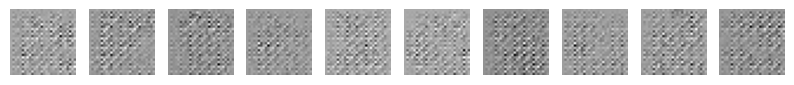

In [ ]:


@tf.function
def train_step(images, labels):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, 28 ,28, 1])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# Training loop
def train(generator, discriminator, gan, epochs, batch_size):
    for epoch in range(epochs):
        for batch in range(len(x_train) // batch_size):
            images = x_train[batch * batch_size: (batch+1) * batch_size]
            labels = y_train[batch * batch_size: (batch+1) * batch_size]

            train_step(images, labels)

        # Output training progress
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            # Generate and save sample images
            noise = tf.random.normal([10, 28 ,28, 1])
            sampled_labels = tf.constant([[i % 10] for i in range(10)], dtype=tf.int32)
            generated_images = generator.predict([noise, sampled_labels])
            generated_images = (generated_images * 0.5) + 0.5  # Rescale images from [-1, 1] to [0, 1]
            fig, axs = plt.subplots(1, 10, figsize=(10, 10))
            for i in range(10):
                axs[i].imshow(generated_images[i], cmap="gray")
                axs[i].axis("off")
            plt.show()

# Train the GAN
EPOCHS = 20000
BATCH_SIZE = 64
train(generator, discriminator, gan, EPOCHS, BATCH_SIZE)